# Final Project (Churn Prediction)
###### Estefania Perez & Daniel Cruz 

### 1. Data Preprocessing

In [214]:
#%pip install imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  

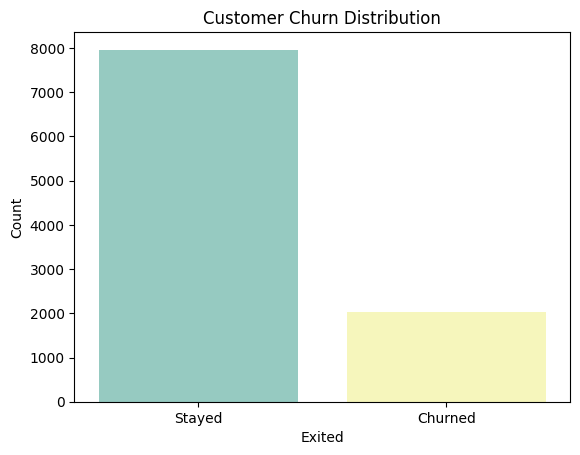

In [215]:
# EDA Summary of Churn_Modeling Dataset
churn_data = pd.read_csv('Churn_Modelling.csv')

print("Dataset Info:")
print(churn_data.info())
print("\n")

print("First 5 rows:")
print(churn_data.head())
print("\n")

print("Dataset Shape:")
print(f"{churn_data.shape[0]} rows, {churn_data.shape[1]} columns\n")

print("\n")
print(f"Chrun Percentage:\n {churn_data['Exited'].value_counts(normalize=True) * 100}")

sns.countplot(x='Exited', hue='Exited', data=churn_data, palette='Set3', legend=False)
plt.title('Customer Churn Distribution')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.show()

In [216]:
'''
Cleaning/Preparing The Chrun Data
- Dropping Irrelevant Columns
- Encoding Categorical Variables
- Splitting into Train/Test Sets (80/20)
'''

#dropping irrelevant columns (RowNumber, CustomerId, Surname)
churn_data = churn_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#Encoding Categorical Variables (Gender (Binary Encoding) and Geography(One-hot encoding))
churn_data['Gender'] = churn_data['Gender'].map({'Female': 0, 'Male':1})
#Need to elaborate why we used get_dummies and drop_first
churn_data = pd.get_dummies(churn_data, columns = ['Geography'], drop_first=True)
print("Data is now Encoded Properly:")
print(churn_data.head())


#False, False = Francex
#True, False = Germany
#False, True = Spain

Data is now Encoded Properly:
   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2       0.00              1          1   
1          608       0   41       1   83807.86              1          0   
2          502       0   42       8  159660.80              3          1   
3          699       0   39       1       0.00              2          0   
4          850       0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0               1        101348.88       1              False            False  
1               1        112542.58       0              False             True  
2               0        113931.57       1              False            False  
3               0         93826.63       0              False            False  
4               1         79084.10       0              False             True  


X_train shape: (8000, 11)
X_test shape: (2000, 11)

y_train distribution:
 Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64
y_test distribution:
 Exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64


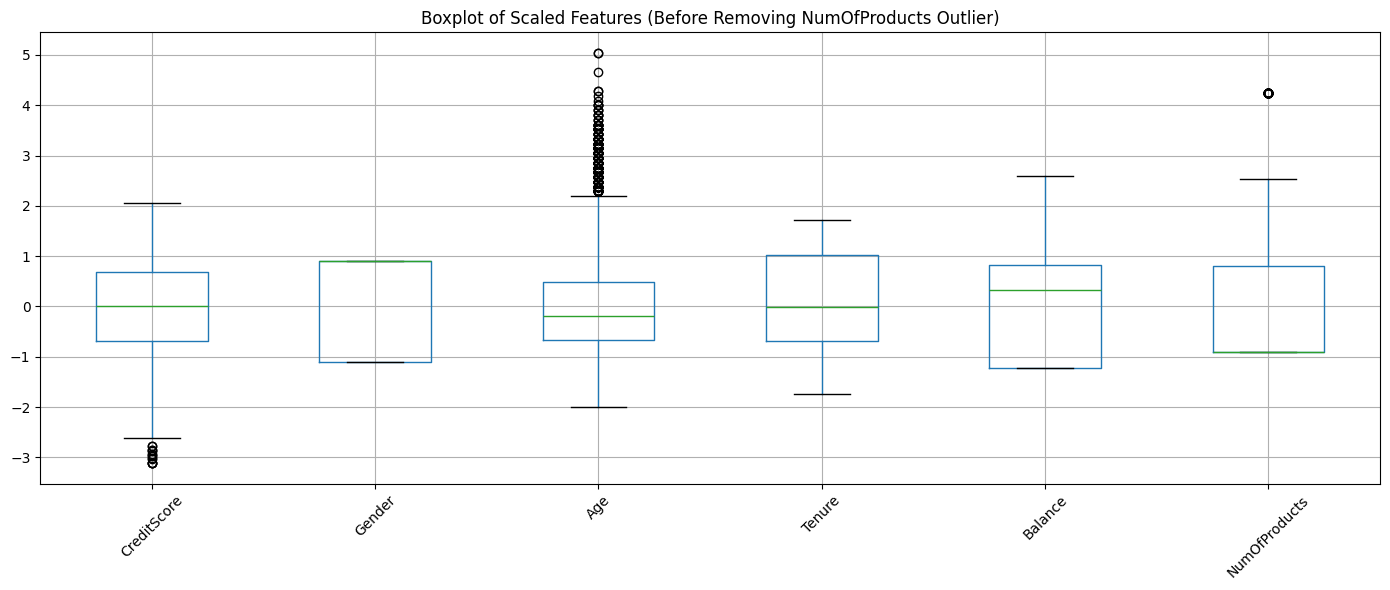


Removed 50 rows with NumOfProducts > 3
X_train shape after removal: (7950, 11)


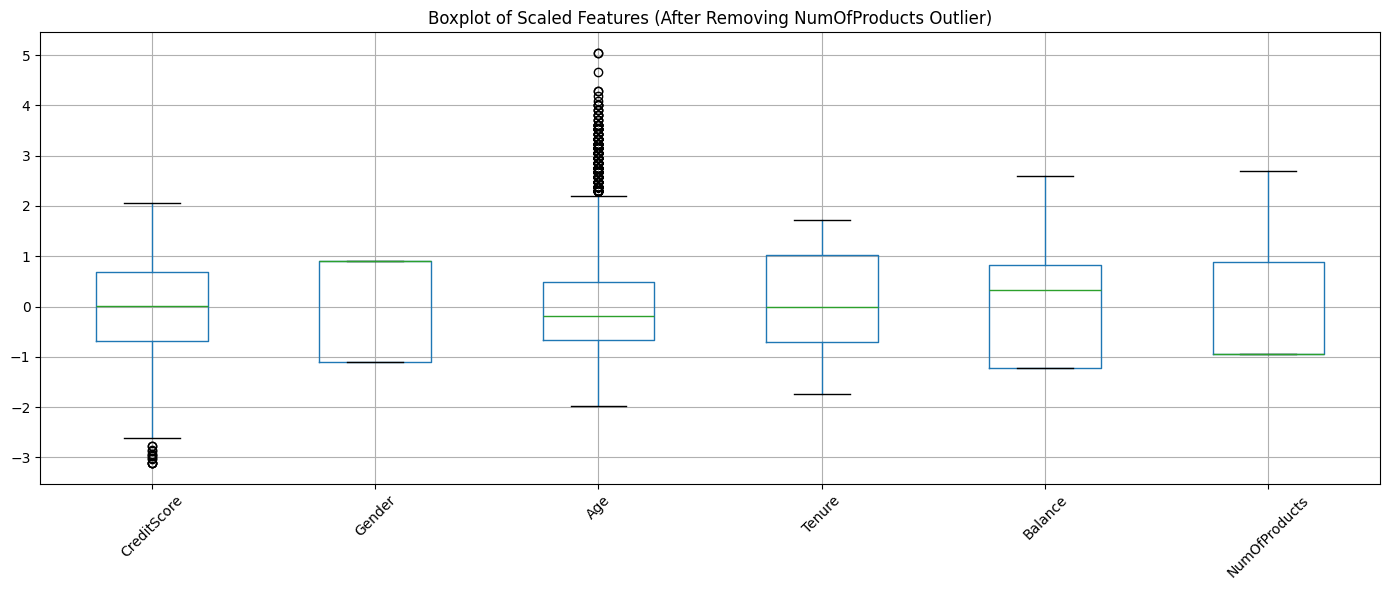


Class distribution after SMOTE:
Exited
1    6370
0    6370
Name: count, dtype: int64


In [217]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Split the dataset into features (X) and target variable (y)
X = churn_data.drop('Exited', axis=1)
y = churn_data['Exited']

#Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Display the shape of training and test sets to verify correct splitting
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\ny_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))

#Scale the training features using StandardScaler and convert the result back to a DataFrame for easier interpretation
scaler_before = StandardScaler()
X_train_scaled_before = scaler_before.fit_transform(X_train)
X_train_scaled_df_before = pd.DataFrame(X_train_scaled_before, columns=X_train.columns)

#Boxplot BEFORE removing NumOfProducts > 3
plt.figure(figsize=(14, 6))
X_train_scaled_df_before.iloc[:, :6].boxplot()
plt.title("Boxplot of Scaled Features (Before Removing NumOfProducts Outlier)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Remove only NumOfProducts outlier
initial_rows = X_train.shape[0]
mask = X_train['NumOfProducts'] <= 3
X_train = X_train[mask]
y_train = y_train[mask]
removed_rows = initial_rows - X_train.shape[0]

print(f"\nRemoved {removed_rows} rows with NumOfProducts > 3")
print("X_train shape after removal:", X_train.shape)

#Scale after removal for boxplo, also used for model training
scaler_after = StandardScaler()
X_train_scaled_after = scaler_after.fit_transform(X_train)
X_train_scaled_df_after = pd.DataFrame(X_train_scaled_after, columns=X_train.columns)

#Boxplot AFTER removing NumOfProducts outlier
plt.figure(figsize=(14, 6))
X_train_scaled_df_after.iloc[:, :6].boxplot()
plt.title("Boxplot of Scaled Features (After Removing NumOfProducts Outlier)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#For SMOTE training with the models
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled_after, y_train)

#Note: We use the same X_test_scaled for evaluating both the SMOTE and non-SMOTE models.
#This ensures a fair comparison, as the test set remains untouched and reflects the original class imbalance.
#SMOTE is only applied to the training data to help the model learn from a balanced dataset.
X_test_scaled = scaler_after.transform(X_test)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

### 2. Model Design and Training

In [219]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# === TRAIN MODELS WITH class_weight='balanced' ===
print("=== Model Performance ===\n")

# Decision Tree
print("Decision Tree: (Without SMOTE)")
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("-" * 50)

print("Decision Tree: (With SMOTE)")
dt_smote = DecisionTreeClassifier(random_state=42)
dt_smote.fit(X_resampled, y_resampled)
y_pred_dt_smote = dt_smote.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_smote):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt_smote))
print("-" * 50)

# MLP 
print("MLP Classifier (With SMOTE):")
mlp_smote = MLPClassifier(random_state=42, max_iter=900)
mlp_smote.fit(X_resampled, y_resampled)
y_pred_mlp_smote = mlp_smote.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp_smote):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp_smote))
print("-" * 50)

print("MLP Classifier (Without SMOTE):")
mlp_model = MLPClassifier(random_state=42, max_iter=900)
mlp_model.fit(X_train_scaled_after, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print("-" * 50)

# Logistic Regression
print("Logistic Regression: (Without SMOTE)")
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled_after, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("-" * 50)

print("Logistic Regression: (With SMOTE)")
lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_resampled, y_resampled)
y_pred_lr_smote = lr_smote.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_smote):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_smote))
print("-" * 50)

# Random Forest
print("Random Forest: (With SMOTE)")
rf_model_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_model_smote.fit(X_resampled, y_resampled)
y_pred_rf_smote = rf_model_smote.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_smote):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_smote))
print("=" * 60)

print("Random Forest: (Without SMOTE)")
rf_model = RandomForestClassifier(
    class_weight = 'balanced',
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train_scaled_after, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("=" * 60)

=== Model Performance ===

Decision Tree: (Without SMOTE)
Accuracy: 0.7735
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1593
           1       0.44      0.43      0.43       407

    accuracy                           0.77      2000
   macro avg       0.65      0.64      0.65      2000
weighted avg       0.77      0.77      0.77      2000

--------------------------------------------------
Decision Tree: (With SMOTE)
Accuracy: 0.7620
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1593
           1       0.43      0.55      0.48       407

    accuracy                           0.76      2000
   macro avg       0.65      0.68      0.66      2000
weighted avg       0.79      0.76      0.77      2000

--------------------------------------------------
MLP Classifier (With SMOTE):
Accuracy: 0.8055
Classification Report:
         

In [221]:
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

print("=== Three Ensemble Methods ===\n")

#Balanced Random Forest (undersampling without replacement)
print("Balanced Random Forest:")
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    replacement=False,      # ensures no duplicate samples in each bootstrap
    random_state=42
)
brf.fit(X_train_scaled_after, y_train)  # uses your scaled, imbalanced train set
y_pred_brf = brf.predict(X_test_scaled) # predicts on your untouched, scaled test set
print(f"Accuracy: {accuracy_score(y_test, y_pred_brf):.4f}")
print(classification_report(y_test, y_pred_brf))
print("-" * 50)

#XGBoost (trained on SMOTE data)
print("XGBoost (with SMOTE):")
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_resampled, y_resampled)       # X_resampled, y_resampled from SMOTE
y_pred_xgb = xgb.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb))
print("-" * 50)

#Stacking Classifier (BRF + XGB + balanced LR → LR meta‑learner)
print("Stacking Classifier (BRF + XGB + LR):")
stack_estimators = [
    ('brf', BalancedRandomForestClassifier(n_estimators=100, replacement=False, random_state=42)),
    ('xgb', xgb),  # reuse the same XGB instance
    ('lr',  LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
]
stack = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    stack_method='predict_proba'
)
stack.fit(X_resampled, y_resampled)
y_pred_stack = stack.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_stack):.4f}")
print(classification_report(y_test, y_pred_stack))
print("=" * 60)

=== Three Ensemble Methods ===

Balanced Random Forest:
Accuracy: 0.7785
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1593
           1       0.47      0.78      0.59       407

    accuracy                           0.78      2000
   macro avg       0.70      0.78      0.72      2000
weighted avg       0.84      0.78      0.80      2000

--------------------------------------------------
XGBoost (with SMOTE):
Accuracy: 0.8420
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1593
           1       0.63      0.53      0.58       407

    accuracy                           0.84      2000
   macro avg       0.76      0.73      0.74      2000
weighted avg       0.83      0.84      0.84      2000

--------------------------------------------------
Stacking Classifier (BRF + XGB + LR):
Accuracy: 0.8450
              precision    recall  f1-score   support

           0       0.8

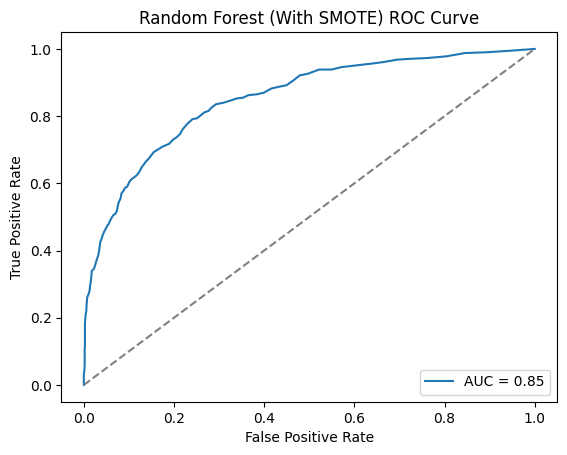

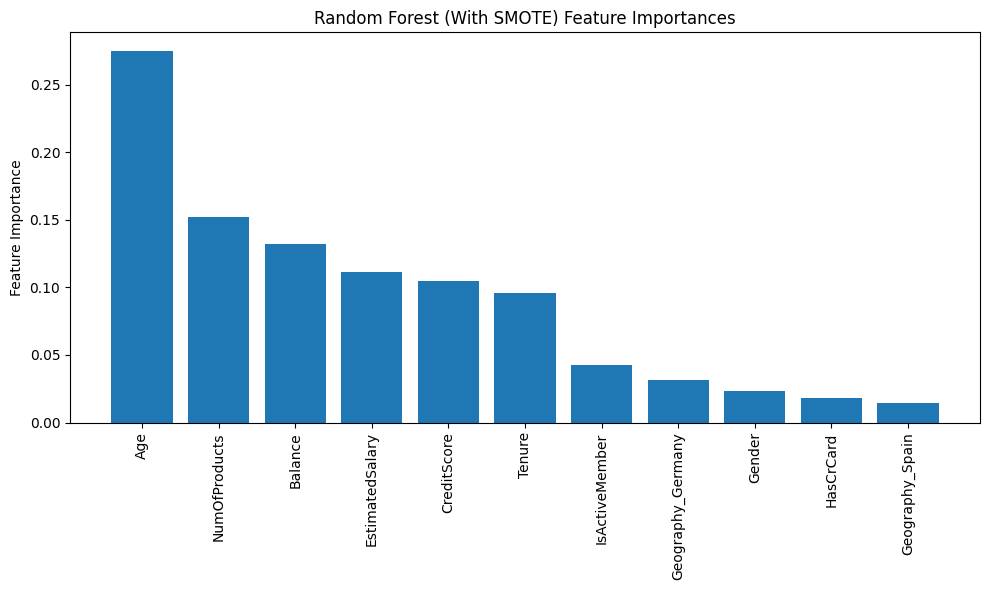

In [223]:
#Our best one is random forest
from sklearn.metrics import roc_curve, auc

#ROC Curve and AUC
y_score_smote = rf_model_smote.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score_smote)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest (With SMOTE) ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 4) Feature Importances
importances = rf_model_smote.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns  # original feature names

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.ylabel("Feature Importance")
plt.title("Random Forest (With SMOTE) Feature Importances")
plt.tight_layout()
plt.show()

### 3. Model Improvements

#### Hyperparamter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

#source that helped: https://michael-fuchs-python.netlify.app/2021/02/03/nn-multi-layer-perceptron-classifier-mlpclassifier/
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (50, 100), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(mlp_model, param_grid, n_jobs=-1, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

grid_pred = grid_search.predict(X_test)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Accuracy: ", accuracy_score(y_test, grid_pred))
print("Classification Report:")
print(classification_report(y_test, grid_pred))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
#https://sklearner.com/scikit-learn-random-search-mlpclassifier/

param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50), (50, 100), (100, 50)],
              'activation': ['relu', 'tanh'],
              'solver': ['adam', 'sgd'],
              'alpha': [0.001, 0.01, 0.1],
              'learning_rate': ['constant', 'adaptive']}

random_search = RandomizedSearchCV(mlp_model, param_distributions=param_grid, n_iter=105, n_jobs=-1, cv=5, verbose=2)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
acc = best_model.score(X_test, y_test)
#print("Best hyperparameters: ", random_search.best_params_)
#print("Accuracy: " + str(acc))
#print("Classification Report:")
#print(classification_report(y_test, best_model.predict(X_test)))

with open('output.txt', 'w') as f: #output is more than 500 lines and wont show properly
    print("Best hyperparameters: ", random_search.best_params_, file=f)
    print("Accuracy: " + str(acc), file=f)
    print("Classification Report:", file=f)
    print(classification_report(y_test, best_model.predict(X_test)), file=f)

"""
Output from the file during the last run was:

Best hyperparameters:  {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.1, 'activation': 'tanh'}
Accuracy: 0.8695
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.51      0.61       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.77      2000
weighted avg       0.86      0.87      0.86      2000
"""

### Model Fusion

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Re-initialize models (with the same parameters you used before)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

# Train both models on resampled training data
rf_model.fit(X_train_resampled, y_train_resampled)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Create soft voting ensemble
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  # soft voting uses predicted probabilities
)

# Fit voting model on the same resampled training data
voting_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_voting = voting_model.predict(X_test)

# Evaluate
print("Soft Voting Classifier (Random Forest + XGBoost):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_voting))



### Regularization Techniques:

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with L2 Regularization (Ridge)
log_reg_l2 = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', random_state=42, max_iter=1000)
log_reg_l2.fit(X_train, y_train)
y_pred_l2 = log_reg_l2.predict(X_test)

print("Logistic Regression with L2 Regularization:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_l2)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_l2))